# Titanic competition with TensorFlow Decision Forests

This notebook will take you through the steps needed to train a baseline Gradient Boosted Trees Model using TensorFlow Decision Forests and creating a submission on the Titanic competition. 

This notebook shows:

1. How to do some basic pre-processing. For example, the passenger names will be tokenized, and ticket names will be splitted in parts.
1. How to train a Gradient Boosted Trees (GBT) with default parameters
1. How to train a GBT with improved default parameters
1. How to tune the parameters of a GBTs
1. How to train and ensemble many GBTs

# Imports dependencies

In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_decision_forests as tfdf

print(f"Found TF-DF {tfdf.__version__}")

Found TF-DF 1.2.0


# Load dataset

In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
serving_df = pd.read_csv("/kaggle/input/titanic/test.csv")

train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Prepare dataset

We will apply the following transformations on the dataset.

1. Tokenize the names. For example, "Braund, Mr. Owen Harris" will become ["Braund", "Mr.", "Owen", "Harris"].
2. Extract any prefix in the ticket. For example ticket "STON/O2. 3101282" will become "STON/O2." and 3101282.

In [3]:
def preprocess(df):
    df = df.copy()
    
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket_number(x):
        return x.split(" ")[-1]
        
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    
    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)                     
    return df
    
preprocessed_train_df = preprocess(train_df)
preprocessed_serving_df = preprocess(serving_df)

preprocessed_train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C85,C,17599,PC
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,113803,NONE
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,NaN,S,373450,NONE


Let's keep the list of the input features of the model. Notably, we don't want to train our model on the "PassengerId" and "Ticket" features.

In [4]:
input_features = list(preprocessed_train_df.columns)
input_features.remove("Ticket")
input_features.remove("PassengerId")
input_features.remove("Survived")
#input_features.remove("Ticket_number")

print(f"Input features: {input_features}")

Input features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Ticket_number', 'Ticket_item']


# Convert Pandas dataset to TensorFlow Dataset

In [5]:
def tokenize_names(features, labels=None):
    """Divite the names into tokens. TF-DF can consume text tokens natively."""
    features["Name"] =  tf.strings.split(features["Name"])
    return features, labels

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(preprocessed_train_df,label="Survived").map(tokenize_names)
serving_ds = tfdf.keras.pd_dataframe_to_tf_dataset(preprocessed_serving_df).map(tokenize_names)

# Train model with default parameters

### Train model

First, we are training a GradientBoostedTreesModel model with the default parameters.

In [6]:
model = tfdf.keras.GradientBoostedTreesModel(
    verbose=0, # Very few logs
    features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
    exclude_non_specified_features=True, # Only use the features in "features"
    random_seed=1234,
)
model.fit(train_ds)

self_evaluation = model.make_inspector().evaluation()
print(f"Accuracy: {self_evaluation.accuracy} Loss:{self_evaluation.loss}")

[INFO 2026-01-03T10:22:50.401859682+00:00 kernel.cc:1214] Loading model from path /tmp/tmp4ro2ckl8/model/ with prefix ef2b5a46c0554bc6
[INFO 2026-01-03T10:22:50.411934767+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:22:50.412060667+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy: 0.8260869383811951 Loss:0.8608942627906799


# Train model with improved default parameters

Now you'll use some specific parameters when creating the GBT model

In [7]:
model = tfdf.keras.GradientBoostedTreesModel(
    verbose=0, # Very few logs
    features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
    exclude_non_specified_features=True, # Only use the features in "features"
    
    #num_trees=2000,
    
    # Only for GBT.
    # A bit slower, but great to understand the model.
    # compute_permutation_variable_importance=True,
    
    # Change the default hyper-parameters
    # hyperparameter_template="benchmark_rank1@v1",
    
    #num_trees=1000,
    #tuner=tuner
    
    min_examples=1,
    categorical_algorithm="RANDOM",
    max_depth=4,
    shrinkage=0.05,
    num_candidate_attributes_ratio=0.2,
    split_axis="SPARSE_OBLIQUE",
    sparse_oblique_normalization="MIN_MAX",
    sparse_oblique_num_projections_exponent=2.0,
    num_trees=5000,
    validation_ratio=0.1,
    random_seed=4459,
    
)
model.fit(train_ds)

self_evaluation = model.make_inspector().evaluation()
print(f"Accuracy: {self_evaluation.accuracy} Loss:{self_evaluation.loss}")

[INFO 2026-01-03T10:22:54.278140374+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0b4th8wi/model/ with prefix e71a9bb134374186
[INFO 2026-01-03T10:22:54.288230712+00:00 decision_forest.cc:661] Model loaded with 129 root(s), 1865 node(s), and 10 input feature(s).
[INFO 2026-01-03T10:22:54.288301847+00:00 kernel.cc:1046] Use fast generic engine


Accuracy: 0.8315789699554443 Loss:0.8363402485847473


Let's look at the model and you can also notice the information about variable importance that the model figured out

In [8]:
model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (11):
	Age
	Cabin
	Embarked
	Fare
	Name
	Parch
	Pclass
	Sex
	SibSp
	Ticket_item
	Ticket_number

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.           "Age"  0.420963 ################
    2.          "Fare"  0.367738 ##########
    3.           "Sex"  0.320783 ######
    4.          "Name"  0.296351 ####
    5.   "Ticket_item"  0.278593 ##
    6. "Ticket_number"  0.265938 #
    7.         "Parch"  0.259509 
    8.      "Embarked"  0.257909 
    9.        "Pclass"  0.254475 

Variable Importance: NUM_AS_ROOT:
    1.           "Age" 35.000000 ################
    2.           "Sex" 27.000000 #####

# Make predictions

In [9]:
def prediction_to_kaggle_format(model, threshold=0.5):
    proba_survive = model.predict(serving_ds, verbose=0)[:,0]
    return pd.DataFrame({
        "PassengerId": serving_df["PassengerId"],
        "Survived": (proba_survive >= threshold).astype(int)
    })

def make_submission(kaggle_predictions):
    path="/kaggle/working/submission.csv"
    kaggle_predictions.to_csv(path, index=False)
    print(f"Submission exported to {path}")
    
kaggle_predictions = prediction_to_kaggle_format(model, threshold=0.5)
make_submission(kaggle_predictions)
!head /kaggle/working/submission.csv
# 4. Grab the raw numbers separately so we can see them!
raw_probs = model.predict(serving_ds, verbose=0)[:,0]
print(f"\nFirst 10 raw probabilities:\n{raw_probs[:10]}")

Submission exported to /kaggle/working/submission.csv
PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,0
899,0
900,1

First 10 raw probabilities:
[0.0703154  0.20781724 0.10857607 0.39420936 0.45613524 0.17702778
 0.41156256 0.1862218  0.7473343  0.06819478]


# Training a model with hyperparameter tunning

Hyper-parameter tuning is enabled by specifying the tuner constructor argument of the model. The tuner object contains all the configuration of the tuner (search space, optimizer, trial and objective).


In [10]:
tuner = tfdf.tuner.RandomSearch(num_trials=1000)
tuner.choice("min_examples", [2, 5, 7, 10])
tuner.choice("categorical_algorithm", ["CART", "RANDOM"])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [3, 4, 5, 6, 8])

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])

#tuner.choice("use_hessian_gain", [True, False])
tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15])
tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0])


tuner.choice("split_axis", ["AXIS_ALIGNED"])
oblique_space = tuner.choice("split_axis", ["SPARSE_OBLIQUE"], merge=True)
oblique_space.choice("sparse_oblique_normalization",
                     ["NONE", "STANDARD_DEVIATION", "MIN_MAX"])
oblique_space.choice("sparse_oblique_weights", ["BINARY", "CONTINUOUS"])
oblique_space.choice("sparse_oblique_num_projections_exponent", [1.0, 1.5])

# Tune the model. Notice the `tuner=tuner`.
tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
tuned_model.fit(train_ds, verbose=0)

tuned_self_evaluation = tuned_model.make_inspector().evaluation()
print(f"Accuracy: {tuned_self_evaluation.accuracy} Loss:{tuned_self_evaluation.loss}")

Use /tmp/tmp4_ezydh4 as temporary training directory


[INFO 2026-01-03T10:25:01.40616993+00:00 kernel.cc:1214] Loading model from path /tmp/tmp4_ezydh4/model/ with prefix aec0e0752a6047c1
[INFO 2026-01-03T10:25:01.422325641+00:00 decision_forest.cc:661] Model loaded with 19 root(s), 589 node(s), and 12 input feature(s).
[INFO 2026-01-03T10:25:01.422373519+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 2026-01-03T10:25:01.42240216+00:00 kernel.cc:1046] Use fast generic engine


Accuracy: 0.9178082346916199 Loss:0.6503586769104004


In [11]:
tuning_logs = tuned_model.make_inspector().tuning_logs()
tuning_logs.head()

,score,evaluation_time,best,min_examples,categorical_algorithm,growing_strategy,max_depth,shrinkage,num_candidate_attributes_ratio,split_axis,sparse_oblique_normalization,sparse_oblique_weights,sparse_oblique_num_projections_exponent,max_num_nodes
0,-0.746789,0.355230,False,10,CART,LOCAL,6.0,0.05,0.9,SPARSE_OBLIQUE,STANDARD_DEVIATION,BINARY,1.0,NaN
1,-0.742386,0.373700,False,10,CART,BEST_FIRST_GLOBAL,NaN,0.15,1.0,SPARSE_OBLIQUE,MIN_MAX,BINARY,1.5,16.0
2,-0.736096,0.501343,False,7,RANDOM,LOCAL,6.0,0.05,0.2,SPARSE_OBLIQUE,STANDARD_DEVIATION,CONTINUOUS,1.5,NaN
3,-0.723823,0.760225,False,2,CART,LOCAL,3.0,0.05,0.5,SPARSE_OBLIQUE,MIN_MAX,CONTINUOUS,1.5,NaN
4,-0.736556,0.795753,False,2,RANDOM,BEST_FIRST_GLOBAL,NaN,0.05,0.9,SPARSE_OBLIQUE,MIN_MAX,CONTINUOUS,1.5,32.0


In the last line in the cell above, you can see the accuracy is higher than previously with default parameters and parameters set by hand.

This is the main idea behing hyperparameter tuning.

For more information you can follow this tutorial: [Automated hyper-parameter tuning](https://www.tensorflow.org/decision_forests/tutorials/automatic_tuning_colab)

# Making an ensemble

Here you'll create 100 models with different seeds and combine their results

This approach removes a little bit the random aspects related to creating ML models

In the GBT creation is used the `honest` parameter. It will use different training examples to infer the structure and the leaf values. This regularization technique trades examples for bias estimates.

In [12]:
predictions = None
num_predictions = 0

for i in range(100):
    print(f"i:{i}")
    # Possible models: GradientBoostedTreesModel or RandomForestModel
    model = tfdf.keras.GradientBoostedTreesModel(
        verbose=0, # Very few logs
        features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
        exclude_non_specified_features=True, # Only use the features in "features"

        #min_examples=1,
        #categorical_algorithm="RANDOM",
        ##max_depth=4,
        #shrinkage=0.05,
        ##num_candidate_attributes_ratio=0.2,
        #split_axis="SPARSE_OBLIQUE",
        #sparse_oblique_normalization="MIN_MAX",
        #sparse_oblique_num_projections_exponent=2.0,
        #num_trees=2000,
        ##validation_ratio=0.0,
        random_seed=i,
        honest=True,
    )
    model.fit(train_ds)
    
    sub_predictions = model.predict(serving_ds, verbose=0)[:,0]
    if predictions is None:
        predictions = sub_predictions
    else:
        predictions += sub_predictions
    num_predictions += 1

predictions/=num_predictions

kaggle_predictions = pd.DataFrame({
        "PassengerId": serving_df["PassengerId"],
        "Survived": (predictions >= 0.5).astype(int)
    })

make_submission(kaggle_predictions)

i:0


[INFO 2026-01-03T10:25:02.783703571+00:00 kernel.cc:1214] Loading model from path /tmp/tmpuzax47ur/model/ with prefix 4fb68c7e070d494d
[INFO 2026-01-03T10:25:02.788263292+00:00 kernel.cc:1046] Use fast generic engine


i:1


[INFO 2026-01-03T10:25:04.541010474+00:00 kernel.cc:1214] Loading model from path /tmp/tmpoigs82up/model/ with prefix 783b2ac845ab4445
[INFO 2026-01-03T10:25:04.560409575+00:00 kernel.cc:1046] Use fast generic engine


i:2


[INFO 2026-01-03T10:25:05.702746664+00:00 kernel.cc:1214] Loading model from path /tmp/tmpzv319ac7/model/ with prefix fe50d4d5ff96469b
[INFO 2026-01-03T10:25:05.707519555+00:00 kernel.cc:1046] Use fast generic engine


i:3


[INFO 2026-01-03T10:25:07.665968114+00:00 kernel.cc:1214] Loading model from path /tmp/tmprt7db8z7/model/ with prefix 579e9820dab14a09
[INFO 2026-01-03T10:25:07.693775111+00:00 kernel.cc:1046] Use fast generic engine


i:4


[INFO 2026-01-03T10:25:08.90649239+00:00 kernel.cc:1214] Loading model from path /tmp/tmpoejdf9aq/model/ with prefix 0635d0e8b1c1485c
[INFO 2026-01-03T10:25:08.912285777+00:00 kernel.cc:1046] Use fast generic engine


i:5


[INFO 2026-01-03T10:25:10.004315902+00:00 kernel.cc:1214] Loading model from path /tmp/tmpzny14l_n/model/ with prefix 7bf75911e9f947ed
[INFO 2026-01-03T10:25:10.007471716+00:00 kernel.cc:1046] Use fast generic engine


i:6


[INFO 2026-01-03T10:25:11.258774629+00:00 kernel.cc:1214] Loading model from path /tmp/tmp6269qlx2/model/ with prefix 992e0ca8c74d4372
[INFO 2026-01-03T10:25:11.266942763+00:00 kernel.cc:1046] Use fast generic engine


i:7


[INFO 2026-01-03T10:25:13.01228631+00:00 kernel.cc:1214] Loading model from path /tmp/tmppz95nn_7/model/ with prefix 9def4d4d51ce4f0a
[INFO 2026-01-03T10:25:13.032391915+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:25:13.032441287+00:00 kernel.cc:1046] Use fast generic engine


i:8


[INFO 2026-01-03T10:25:14.417341201+00:00 kernel.cc:1214] Loading model from path /tmp/tmpty3duei6/model/ with prefix 0b7a2c243a874a06
[INFO 2026-01-03T10:25:14.427625384+00:00 kernel.cc:1046] Use fast generic engine


i:9


[INFO 2026-01-03T10:25:16.590572959+00:00 kernel.cc:1214] Loading model from path /tmp/tmpu2_fai6v/model/ with prefix 685ed1fba9cd4d3d
[INFO 2026-01-03T10:25:16.607190655+00:00 kernel.cc:1046] Use fast generic engine


i:10


[INFO 2026-01-03T10:25:17.843469108+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0db74_uv/model/ with prefix f5082674d21c4d72
[INFO 2026-01-03T10:25:17.849580713+00:00 kernel.cc:1046] Use fast generic engine


i:11


[INFO 2026-01-03T10:25:19.44271425+00:00 kernel.cc:1214] Loading model from path /tmp/tmps_bhsqw8/model/ with prefix be6fbb9d7cc14580
[INFO 2026-01-03T10:25:19.458327197+00:00 kernel.cc:1046] Use fast generic engine


i:12


[INFO 2026-01-03T10:25:20.786473949+00:00 kernel.cc:1214] Loading model from path /tmp/tmphij5_6oa/model/ with prefix a0f6266029154cb2
[INFO 2026-01-03T10:25:20.792725551+00:00 kernel.cc:1046] Use fast generic engine


i:13


[INFO 2026-01-03T10:25:22.352081822+00:00 kernel.cc:1214] Loading model from path /tmp/tmp2xu5jmse/model/ with prefix 47baad3bc48140e1
[INFO 2026-01-03T10:25:22.364444601+00:00 kernel.cc:1046] Use fast generic engine


i:14


[INFO 2026-01-03T10:25:23.607813702+00:00 kernel.cc:1214] Loading model from path /tmp/tmpg2x1wjfy/model/ with prefix 0e8029763e7e4978
[INFO 2026-01-03T10:25:23.616976861+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:25:23.617038262+00:00 kernel.cc:1046] Use fast generic engine


i:15


[INFO 2026-01-03T10:25:24.856183549+00:00 kernel.cc:1214] Loading model from path /tmp/tmpmp28st2z/model/ with prefix 66000272ae1d4bdc
[INFO 2026-01-03T10:25:24.864248564+00:00 kernel.cc:1046] Use fast generic engine


i:16


[INFO 2026-01-03T10:25:26.316967008+00:00 kernel.cc:1214] Loading model from path /tmp/tmphfnjztrf/model/ with prefix 080656d7188e473a
[INFO 2026-01-03T10:25:26.330424426+00:00 kernel.cc:1046] Use fast generic engine


i:17


[INFO 2026-01-03T10:25:27.809397977+00:00 kernel.cc:1214] Loading model from path /tmp/tmpcfjswu68/model/ with prefix b060ed873e2b4b4d
[INFO 2026-01-03T10:25:27.822823358+00:00 kernel.cc:1046] Use fast generic engine


i:18


[INFO 2026-01-03T10:25:29.262341961+00:00 kernel.cc:1214] Loading model from path /tmp/tmp9jq87nbf/model/ with prefix 6c5c4ea84f594ecc
[INFO 2026-01-03T10:25:29.274497202+00:00 kernel.cc:1046] Use fast generic engine


i:19


[INFO 2026-01-03T10:25:30.95778572+00:00 kernel.cc:1214] Loading model from path /tmp/tmpje9hmrrr/model/ with prefix a9e9136b2c9844c0
[INFO 2026-01-03T10:25:30.976150926+00:00 kernel.cc:1046] Use fast generic engine


i:20


[INFO 2026-01-03T10:25:32.562987769+00:00 kernel.cc:1214] Loading model from path /tmp/tmpnsr2k5rj/model/ with prefix ba5ffa25d2d64c35
[INFO 2026-01-03T10:25:32.579234912+00:00 kernel.cc:1046] Use fast generic engine


i:21


[INFO 2026-01-03T10:25:33.753921241+00:00 kernel.cc:1214] Loading model from path /tmp/tmpkawqrnjk/model/ with prefix 5bdaadd0be4a4252
[INFO 2026-01-03T10:25:33.759559762+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:25:33.759615944+00:00 kernel.cc:1046] Use fast generic engine


i:22


[INFO 2026-01-03T10:25:34.984446487+00:00 kernel.cc:1214] Loading model from path /tmp/tmp_oj9qbz2/model/ with prefix 9bfa827a51624d7f
[INFO 2026-01-03T10:25:34.990477945+00:00 kernel.cc:1046] Use fast generic engine


i:23


[INFO 2026-01-03T10:25:36.387456846+00:00 kernel.cc:1214] Loading model from path /tmp/tmpwl9t802j/model/ with prefix 1d876669c52942ef
[INFO 2026-01-03T10:25:36.396798153+00:00 kernel.cc:1046] Use fast generic engine


i:24


[INFO 2026-01-03T10:25:37.623358076+00:00 kernel.cc:1214] Loading model from path /tmp/tmpmjg5tjgk/model/ with prefix 268ba2e014b74c0c
[INFO 2026-01-03T10:25:37.629380138+00:00 kernel.cc:1046] Use fast generic engine


i:25


[INFO 2026-01-03T10:25:39.047062646+00:00 kernel.cc:1214] Loading model from path /tmp/tmphybbl_wz/model/ with prefix c67d8b40f5ec43c3
[INFO 2026-01-03T10:25:39.059268+00:00 kernel.cc:1046] Use fast generic engine


i:26


[INFO 2026-01-03T10:25:40.50770882+00:00 kernel.cc:1214] Loading model from path /tmp/tmpdewep4sl/model/ with prefix 6a63dd3265b94080
[INFO 2026-01-03T10:25:40.51865429+00:00 kernel.cc:1046] Use fast generic engine


i:27


[INFO 2026-01-03T10:25:41.782075168+00:00 kernel.cc:1214] Loading model from path /tmp/tmpvbfv8gp5/model/ with prefix b4826f6d3eae4b77
[INFO 2026-01-03T10:25:41.789914276+00:00 kernel.cc:1046] Use fast generic engine


i:28


[INFO 2026-01-03T10:25:43.001622994+00:00 kernel.cc:1214] Loading model from path /tmp/tmp9y13i15i/model/ with prefix 2947c13849e74a7d
[INFO 2026-01-03T10:25:43.007060755+00:00 kernel.cc:1046] Use fast generic engine


i:29


[INFO 2026-01-03T10:25:44.558340126+00:00 kernel.cc:1214] Loading model from path /tmp/tmpd2t5nyz3/model/ with prefix 9a19348afcbe4df8
[INFO 2026-01-03T10:25:44.571548203+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:25:44.571596082+00:00 kernel.cc:1046] Use fast generic engine


i:30


[INFO 2026-01-03T10:25:46.63517669+00:00 kernel.cc:1214] Loading model from path /tmp/tmpn99yycf1/model/ with prefix 26cddaedf5ab40f8
[INFO 2026-01-03T10:25:46.662444516+00:00 kernel.cc:1046] Use fast generic engine


i:31


[INFO 2026-01-03T10:25:48.634775143+00:00 kernel.cc:1214] Loading model from path /tmp/tmpp19exs9s/model/ with prefix 0445c82b65b2401e
[INFO 2026-01-03T10:25:48.646560452+00:00 kernel.cc:1046] Use fast generic engine


i:32


[INFO 2026-01-03T10:25:49.918656325+00:00 kernel.cc:1214] Loading model from path /tmp/tmpaexvryxj/model/ with prefix 4f99e2582e6f49ba
[INFO 2026-01-03T10:25:49.92509773+00:00 kernel.cc:1046] Use fast generic engine


i:33


[INFO 2026-01-03T10:25:51.440265113+00:00 kernel.cc:1214] Loading model from path /tmp/tmppm7s2xfh/model/ with prefix 1930f32134bd49a7
[INFO 2026-01-03T10:25:51.45402422+00:00 kernel.cc:1046] Use fast generic engine


i:34


[INFO 2026-01-03T10:25:52.807281171+00:00 kernel.cc:1214] Loading model from path /tmp/tmp3tc9ipv9/model/ with prefix 2da9dbdca429444d
[INFO 2026-01-03T10:25:52.816355883+00:00 kernel.cc:1046] Use fast generic engine


i:35


[INFO 2026-01-03T10:25:54.123567402+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0s15in8b/model/ with prefix 2c267d2df03c43e0
[INFO 2026-01-03T10:25:54.131913935+00:00 kernel.cc:1046] Use fast generic engine


i:36


[INFO 2026-01-03T10:25:55.744301247+00:00 kernel.cc:1214] Loading model from path /tmp/tmpmdxds5dw/model/ with prefix 04e7c3a6ef5f40a8
[INFO 2026-01-03T10:25:55.758613388+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:25:55.758665334+00:00 kernel.cc:1046] Use fast generic engine


i:37


[INFO 2026-01-03T10:25:57.157507638+00:00 kernel.cc:1214] Loading model from path /tmp/tmpmni0nz8t/model/ with prefix 0d43efc713a34f86
[INFO 2026-01-03T10:25:57.166314816+00:00 kernel.cc:1046] Use fast generic engine


i:38


[INFO 2026-01-03T10:25:58.756306494+00:00 kernel.cc:1214] Loading model from path /tmp/tmpff9l2lyn/model/ with prefix eab6d08bc6ca41f1
[INFO 2026-01-03T10:25:58.771133325+00:00 kernel.cc:1046] Use fast generic engine


i:39


[INFO 2026-01-03T10:26:00.284131563+00:00 kernel.cc:1214] Loading model from path /tmp/tmpxsq7tde7/model/ with prefix 7ffcd534ffda4708
[INFO 2026-01-03T10:26:00.298429959+00:00 kernel.cc:1046] Use fast generic engine


i:40


[INFO 2026-01-03T10:26:01.461876716+00:00 kernel.cc:1214] Loading model from path /tmp/tmpcu47kyoj/model/ with prefix 7dbbcc0fef7b4e3e
[INFO 2026-01-03T10:26:01.466977129+00:00 kernel.cc:1046] Use fast generic engine


i:41


[INFO 2026-01-03T10:26:03.321514918+00:00 kernel.cc:1214] Loading model from path /tmp/tmp9gwrodr0/model/ with prefix 3bb84bd640b74806
[INFO 2026-01-03T10:26:03.337202785+00:00 kernel.cc:1046] Use fast generic engine


i:42


[INFO 2026-01-03T10:26:04.685786981+00:00 kernel.cc:1214] Loading model from path /tmp/tmp09bpmp8r/model/ with prefix 5d739bf66e83497a
[INFO 2026-01-03T10:26:04.69525084+00:00 kernel.cc:1046] Use fast generic engine


i:43


[INFO 2026-01-03T10:26:06.38604436+00:00 kernel.cc:1214] Loading model from path /tmp/tmplef_m8yk/model/ with prefix 7dae4305b5624b3a
[INFO 2026-01-03T10:26:06.403232484+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:26:06.403282696+00:00 kernel.cc:1046] Use fast generic engine


i:44


[INFO 2026-01-03T10:26:07.776966419+00:00 kernel.cc:1214] Loading model from path /tmp/tmpad8p3e_g/model/ with prefix c317c1407e6b4523
[INFO 2026-01-03T10:26:07.78714535+00:00 kernel.cc:1046] Use fast generic engine


i:45


[INFO 2026-01-03T10:26:08.911095889+00:00 kernel.cc:1214] Loading model from path /tmp/tmpgdql4o1i/model/ with prefix 642ed71810f34b6a
[INFO 2026-01-03T10:26:08.914749312+00:00 kernel.cc:1046] Use fast generic engine


i:46


[INFO 2026-01-03T10:26:10.432839341+00:00 kernel.cc:1214] Loading model from path /tmp/tmpdv38jf96/model/ with prefix cbe35f2789b64c1d
[INFO 2026-01-03T10:26:10.447682365+00:00 kernel.cc:1046] Use fast generic engine


i:47


[INFO 2026-01-03T10:26:11.949396284+00:00 kernel.cc:1214] Loading model from path /tmp/tmpsa0x67iv/model/ with prefix c91fe37eac944a62
[INFO 2026-01-03T10:26:11.963241575+00:00 kernel.cc:1046] Use fast generic engine


i:48


[INFO 2026-01-03T10:26:13.140663032+00:00 kernel.cc:1214] Loading model from path /tmp/tmpoig3ba4_/model/ with prefix 89cef88448e049b6
[INFO 2026-01-03T10:26:13.145934266+00:00 kernel.cc:1046] Use fast generic engine


i:49


[INFO 2026-01-03T10:26:14.464153131+00:00 kernel.cc:1214] Loading model from path /tmp/tmpa6skukt4/model/ with prefix ef8c4b830bc3449c
[INFO 2026-01-03T10:26:14.47106925+00:00 kernel.cc:1046] Use fast generic engine


i:50


[INFO 2026-01-03T10:26:16.063434443+00:00 kernel.cc:1214] Loading model from path /tmp/tmp3c2wbyhk/model/ with prefix 1c3d096468084067
[INFO 2026-01-03T10:26:16.076606198+00:00 kernel.cc:1046] Use fast generic engine


i:51


[INFO 2026-01-03T10:26:17.793787218+00:00 kernel.cc:1214] Loading model from path /tmp/tmp775px9j5/model/ with prefix f1a487aba6da4601
[INFO 2026-01-03T10:26:17.809589866+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:26:17.809644526+00:00 kernel.cc:1046] Use fast generic engine


i:52


[INFO 2026-01-03T10:26:19.134035261+00:00 kernel.cc:1214] Loading model from path /tmp/tmp2hk37_zl/model/ with prefix 1bc6f066a37f44da
[INFO 2026-01-03T10:26:19.141790514+00:00 kernel.cc:1046] Use fast generic engine


i:53


[INFO 2026-01-03T10:26:20.572604755+00:00 kernel.cc:1214] Loading model from path /tmp/tmpeu8i3dgb/model/ with prefix 8bd9a62589de4172
[INFO 2026-01-03T10:26:20.581139024+00:00 kernel.cc:1046] Use fast generic engine


i:54


[INFO 2026-01-03T10:26:21.769139406+00:00 kernel.cc:1214] Loading model from path /tmp/tmpyb_8tju0/model/ with prefix 7a29e7d14a274571
[INFO 2026-01-03T10:26:21.773041988+00:00 kernel.cc:1046] Use fast generic engine


i:55


[INFO 2026-01-03T10:26:23.472103211+00:00 kernel.cc:1214] Loading model from path /tmp/tmp40sd4a5k/model/ with prefix a3209a1c3ced4206
[INFO 2026-01-03T10:26:23.487369501+00:00 kernel.cc:1046] Use fast generic engine


i:56


[INFO 2026-01-03T10:26:24.869689206+00:00 kernel.cc:1214] Loading model from path /tmp/tmpijileik3/model/ with prefix 52ddc6f1015d4b0f
[INFO 2026-01-03T10:26:24.880587699+00:00 kernel.cc:1046] Use fast generic engine


i:57


[INFO 2026-01-03T10:26:26.735987895+00:00 kernel.cc:1214] Loading model from path /tmp/tmpc6r0t8uh/model/ with prefix f12848b355e54514
[INFO 2026-01-03T10:26:26.740869526+00:00 kernel.cc:1046] Use fast generic engine


i:58


[INFO 2026-01-03T10:26:28.024603023+00:00 kernel.cc:1214] Loading model from path /tmp/tmp3jjjftp2/model/ with prefix 4d77bca9ef9a432e
[INFO 2026-01-03T10:26:28.03177621+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:26:28.031822249+00:00 kernel.cc:1046] Use fast generic engine


i:59


[INFO 2026-01-03T10:26:29.566646705+00:00 kernel.cc:1214] Loading model from path /tmp/tmpbb30cdl0/model/ with prefix 211e3920c52d4c93
[INFO 2026-01-03T10:26:29.577955676+00:00 kernel.cc:1046] Use fast generic engine


i:60


[INFO 2026-01-03T10:26:31.082387732+00:00 kernel.cc:1214] Loading model from path /tmp/tmpc1i6_xfw/model/ with prefix be0ddf40c5d247f2
[INFO 2026-01-03T10:26:31.093063756+00:00 kernel.cc:1046] Use fast generic engine


i:61


[INFO 2026-01-03T10:26:32.35530693+00:00 kernel.cc:1214] Loading model from path /tmp/tmpk4lczxe4/model/ with prefix 203515bc520246a7
[INFO 2026-01-03T10:26:32.361115847+00:00 kernel.cc:1046] Use fast generic engine


i:62


[INFO 2026-01-03T10:26:34.470600583+00:00 kernel.cc:1214] Loading model from path /tmp/tmpzc_3wafw/model/ with prefix 380dbc3a8a3b48ae
[INFO 2026-01-03T10:26:34.497046069+00:00 kernel.cc:1046] Use fast generic engine


i:63


[INFO 2026-01-03T10:26:35.940177811+00:00 kernel.cc:1214] Loading model from path /tmp/tmp8bcq_blb/model/ with prefix d51b6aee9312400d
[INFO 2026-01-03T10:26:35.950557761+00:00 kernel.cc:1046] Use fast generic engine


i:64


[INFO 2026-01-03T10:26:37.250429458+00:00 kernel.cc:1214] Loading model from path /tmp/tmpmra8actm/model/ with prefix 2335a9bf2e844952
[INFO 2026-01-03T10:26:37.258524819+00:00 kernel.cc:1046] Use fast generic engine


i:65


[INFO 2026-01-03T10:26:38.42303222+00:00 kernel.cc:1214] Loading model from path /tmp/tmpoe1lu0um/model/ with prefix e2eba8b75be148cb
[INFO 2026-01-03T10:26:38.428937446+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:26:38.428994055+00:00 kernel.cc:1046] Use fast generic engine


i:66


[INFO 2026-01-03T10:26:39.636764882+00:00 kernel.cc:1214] Loading model from path /tmp/tmphpjfj61j/model/ with prefix d72bbef99d594bb9
[INFO 2026-01-03T10:26:39.643205766+00:00 kernel.cc:1046] Use fast generic engine


i:67


[INFO 2026-01-03T10:26:41.346983724+00:00 kernel.cc:1214] Loading model from path /tmp/tmplbumbwqs/model/ with prefix e7ebc186070742e0
[INFO 2026-01-03T10:26:41.366495372+00:00 kernel.cc:1046] Use fast generic engine


i:68


[INFO 2026-01-03T10:26:42.786058295+00:00 kernel.cc:1214] Loading model from path /tmp/tmp8x3erpc_/model/ with prefix 628b9e0611774540
[INFO 2026-01-03T10:26:42.797773808+00:00 kernel.cc:1046] Use fast generic engine


i:69


[INFO 2026-01-03T10:26:44.031694957+00:00 kernel.cc:1214] Loading model from path /tmp/tmpczrmu1ya/model/ with prefix 7f0c57a57b184a00
[INFO 2026-01-03T10:26:44.038626257+00:00 kernel.cc:1046] Use fast generic engine


i:70


[INFO 2026-01-03T10:26:45.356798045+00:00 kernel.cc:1214] Loading model from path /tmp/tmp42d16bwn/model/ with prefix 11d952560a93428b
[INFO 2026-01-03T10:26:45.365838903+00:00 kernel.cc:1046] Use fast generic engine


i:71


[INFO 2026-01-03T10:26:46.730939038+00:00 kernel.cc:1214] Loading model from path /tmp/tmppm0zx0ms/model/ with prefix ab5fffc6dcf84c63
[INFO 2026-01-03T10:26:46.738540532+00:00 kernel.cc:1046] Use fast generic engine


i:72


[INFO 2026-01-03T10:26:48.451111342+00:00 kernel.cc:1214] Loading model from path /tmp/tmpdp14yi_p/model/ with prefix 3ffcb35572154ca0
[INFO 2026-01-03T10:26:48.46956472+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:26:48.469617633+00:00 kernel.cc:1046] Use fast generic engine


i:73


[INFO 2026-01-03T10:26:49.704792838+00:00 kernel.cc:1214] Loading model from path /tmp/tmpge9qee23/model/ with prefix 4ba8b88389cc4814
[INFO 2026-01-03T10:26:49.711950267+00:00 kernel.cc:1046] Use fast generic engine


i:74


[INFO 2026-01-03T10:26:51.125240296+00:00 kernel.cc:1214] Loading model from path /tmp/tmp3g6s0vpe/model/ with prefix 930006a3669e4fff
[INFO 2026-01-03T10:26:51.137509552+00:00 kernel.cc:1046] Use fast generic engine


i:75


[INFO 2026-01-03T10:26:52.428908747+00:00 kernel.cc:1214] Loading model from path /tmp/tmpm36zjy7b/model/ with prefix 47210b0d74c344a3
[INFO 2026-01-03T10:26:52.438171048+00:00 kernel.cc:1046] Use fast generic engine


i:76


[INFO 2026-01-03T10:26:53.576846215+00:00 kernel.cc:1214] Loading model from path /tmp/tmpss6u6_k6/model/ with prefix 5d3090d1b8fa4c37
[INFO 2026-01-03T10:26:53.583025507+00:00 kernel.cc:1046] Use fast generic engine


i:77


[INFO 2026-01-03T10:26:54.731407093+00:00 kernel.cc:1214] Loading model from path /tmp/tmpyu4d5lct/model/ with prefix caf4140dadaf4fe3
[INFO 2026-01-03T10:26:54.736403406+00:00 kernel.cc:1046] Use fast generic engine


i:78


[INFO 2026-01-03T10:26:55.924432829+00:00 kernel.cc:1214] Loading model from path /tmp/tmpkb6rxgxl/model/ with prefix 318113962d19467a
[INFO 2026-01-03T10:26:55.931535665+00:00 kernel.cc:1046] Use fast generic engine


i:79


[INFO 2026-01-03T10:26:57.143062444+00:00 kernel.cc:1214] Loading model from path /tmp/tmp1f91e6ct/model/ with prefix 5518699d5155435e
[INFO 2026-01-03T10:26:57.150863036+00:00 kernel.cc:1046] Use fast generic engine


i:80


[INFO 2026-01-03T10:26:58.483236804+00:00 kernel.cc:1214] Loading model from path /tmp/tmpi2v8h0lv/model/ with prefix d093fc5b1c3849e8
[INFO 2026-01-03T10:26:58.493287493+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:26:58.493335012+00:00 kernel.cc:1046] Use fast generic engine


i:81


[INFO 2026-01-03T10:26:59.861824716+00:00 kernel.cc:1214] Loading model from path /tmp/tmpv8u5awl6/model/ with prefix afcfbe33899445f4
[INFO 2026-01-03T10:26:59.874085597+00:00 kernel.cc:1046] Use fast generic engine


i:82


[INFO 2026-01-03T10:27:01.181218245+00:00 kernel.cc:1214] Loading model from path /tmp/tmpv6s60w_8/model/ with prefix 0653bbda1d174e64
[INFO 2026-01-03T10:27:01.191499509+00:00 kernel.cc:1046] Use fast generic engine


i:83


[INFO 2026-01-03T10:27:02.48786343+00:00 kernel.cc:1214] Loading model from path /tmp/tmpylhgw56f/model/ with prefix dd71fbda4fd24c88
[INFO 2026-01-03T10:27:02.496667612+00:00 kernel.cc:1046] Use fast generic engine


i:84


[INFO 2026-01-03T10:27:04.059632346+00:00 kernel.cc:1214] Loading model from path /tmp/tmplq3hrc45/model/ with prefix d89d4de426c74cfb
[INFO 2026-01-03T10:27:04.076067908+00:00 kernel.cc:1046] Use fast generic engine


i:85


[INFO 2026-01-03T10:27:06.14292672+00:00 kernel.cc:1214] Loading model from path /tmp/tmpbxh0sozv/model/ with prefix 1e078b1eb0bd4179
[INFO 2026-01-03T10:27:06.150703961+00:00 kernel.cc:1046] Use fast generic engine


i:86


[INFO 2026-01-03T10:27:07.795468761+00:00 kernel.cc:1214] Loading model from path /tmp/tmpbp_73yu8/model/ with prefix 142d615d5f21419b
[INFO 2026-01-03T10:27:07.814050122+00:00 kernel.cc:1046] Use fast generic engine


i:87


[INFO 2026-01-03T10:27:09.487665864+00:00 kernel.cc:1214] Loading model from path /tmp/tmpm9ugp5nm/model/ with prefix 208b4eb322a1407c
[INFO 2026-01-03T10:27:09.508011372+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:27:09.508085357+00:00 kernel.cc:1046] Use fast generic engine


i:88


[INFO 2026-01-03T10:27:10.967079408+00:00 kernel.cc:1214] Loading model from path /tmp/tmpl00ajqfh/model/ with prefix 5008228bdd024c77
[INFO 2026-01-03T10:27:10.979458493+00:00 kernel.cc:1046] Use fast generic engine


i:89


[INFO 2026-01-03T10:27:12.164100671+00:00 kernel.cc:1214] Loading model from path /tmp/tmp4xue5hab/model/ with prefix 10109f49a9794251
[INFO 2026-01-03T10:27:12.169632759+00:00 kernel.cc:1046] Use fast generic engine


i:90


[INFO 2026-01-03T10:27:13.52667094+00:00 kernel.cc:1214] Loading model from path /tmp/tmp_suieej6/model/ with prefix 1d61f76d00db4adf
[INFO 2026-01-03T10:27:13.537588711+00:00 kernel.cc:1046] Use fast generic engine


i:91


[INFO 2026-01-03T10:27:14.786629236+00:00 kernel.cc:1214] Loading model from path /tmp/tmp9t3inch6/model/ with prefix bfc9df68b1194e6a
[INFO 2026-01-03T10:27:14.793640435+00:00 kernel.cc:1046] Use fast generic engine


i:92


[INFO 2026-01-03T10:27:16.412667704+00:00 kernel.cc:1214] Loading model from path /tmp/tmp9v4apfhi/model/ with prefix ddff5c5b6b2e4d1c
[INFO 2026-01-03T10:27:16.430577435+00:00 kernel.cc:1046] Use fast generic engine


i:93


[INFO 2026-01-03T10:27:17.828702151+00:00 kernel.cc:1214] Loading model from path /tmp/tmp2eihmtmi/model/ with prefix 328fefa1ec154d30
[INFO 2026-01-03T10:27:17.839562818+00:00 kernel.cc:1046] Use fast generic engine


i:94


[INFO 2026-01-03T10:27:19.102961973+00:00 kernel.cc:1214] Loading model from path /tmp/tmp8v_8x3nk/model/ with prefix 5e05249e5597464e
[INFO 2026-01-03T10:27:19.109696741+00:00 kernel.cc:1046] Use fast generic engine


i:95


[INFO 2026-01-03T10:27:20.649658614+00:00 kernel.cc:1214] Loading model from path /tmp/tmp_9fpm6w7/model/ with prefix 68535af3aa2a44f9
[INFO 2026-01-03T10:27:20.658616583+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:27:20.658670144+00:00 kernel.cc:1046] Use fast generic engine


i:96


[INFO 2026-01-03T10:27:22.12372442+00:00 kernel.cc:1214] Loading model from path /tmp/tmpvcj99i1q/model/ with prefix 1971148980744b62
[INFO 2026-01-03T10:27:22.134872737+00:00 kernel.cc:1046] Use fast generic engine


i:97


[INFO 2026-01-03T10:27:23.463800823+00:00 kernel.cc:1214] Loading model from path /tmp/tmphu7rxcld/model/ with prefix 42508e0f9a6849f9
[INFO 2026-01-03T10:27:23.470101366+00:00 kernel.cc:1046] Use fast generic engine


i:98


[INFO 2026-01-03T10:27:24.764752756+00:00 kernel.cc:1214] Loading model from path /tmp/tmpjt22hchw/model/ with prefix 459ad524b09b47f6
[INFO 2026-01-03T10:27:24.772415995+00:00 kernel.cc:1046] Use fast generic engine


i:99


[INFO 2026-01-03T10:27:26.334369174+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0rfsnozh/model/ with prefix a96e103644d5481a
[INFO 2026-01-03T10:27:26.349188555+00:00 kernel.cc:1046] Use fast generic engine


Submission exported to /kaggle/working/submission.csv


In [13]:
print(kaggle_predictions["Survived"].value_counts())

0    275
1    143
Name: Survived, dtype: int64


In [14]:
inspector = model.make_inspector()
print(f"Model type: {inspector.model_type()}")

# Look at the "Variable Importances"
# SUM_SCORE tells us how often a feature was used to split a tree
importances = inspector.variable_importances()["SUM_SCORE"]
for importance in importances:
    print(importance)

Model type: GRADIENT_BOOSTED_TREES
("Fare" (1; #3), 185.78414426095287)
("Sex" (4; #7), 178.9200153996935)
("Name" (5; #4), 165.94886933210148)
("Age" (1; #0), 121.95399654841822)
("Ticket_item" (4; #9), 104.37513519957429)
("Pclass" (1; #6), 52.217200391809456)
("Embarked" (4; #2), 34.5751259092649)
("SibSp" (1; #8), 24.31657773004281)
("Ticket_number" (4; #10), 19.45491489219421)
("Parch" (1; #5), 5.99614312115591)


# What is next

If you want to learn more about TensorFlow Decision Forests and its advanced features, you can follow the official documentation [here](https://www.tensorflow.org/decision_forests) 

In [15]:
import re

def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# Apply this to both our training and serving data
train_df['Title'] = train_df['Name'].apply(extract_title)
serving_df['Title'] = serving_df['Name'].apply(extract_title)

print(train_df['Title'].value_counts())

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64


In [16]:
# Create a mapping dictionary
title_mapping = {
    "Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master",
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
    "Dr": "Rare", "Rev": "Rare", "Col": "Rare", "Major": "Rare", 
    "Countess": "Rare", "Capt": "Rare", "Sir": "Rare", "Lady": "Rare", 
    "Don": "Rare", "Jonkheer": "Rare"
}

# Apply the mapping
train_df['Title'] = train_df['Title'].map(title_mapping)
serving_df['Title'] = serving_df['Title'].map(title_mapping)

# Let's check our new consolidated groups
print(train_df['Title'].value_counts())

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64


In [17]:
# 1. Update the preprocessed dataframes with the Title column
preprocessed_train_df['Title'] = train_df['Title']
preprocessed_serving_df['Title'] = serving_df['Title']

# 2. Re-create the TensorFlow datasets so they "see" the new column
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    preprocessed_train_df, 
    label="Survived"
).map(tokenize_names)

serving_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    preprocessed_serving_df
).map(tokenize_names)

print("Datasets updated successfully with the 'Title' feature! ✅")

Datasets updated successfully with the 'Title' feature! ✅


In [18]:
predictions = None
num_predictions = 0

# 1. Train the 100-model ensemble with the updated datasets
for i in range(100):
    if i % 10 == 0: 
        print(f"Training model i:{i}...")
        
    model = tfdf.keras.GradientBoostedTreesModel(
        verbose=0,
        features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
        exclude_non_specified_features=True,
        random_seed=i,
        honest=True,
    )
    model.fit(train_ds)
    
    # 2. Get probabilities from each model
    sub_predictions = model.predict(serving_ds, verbose=0)[:,0]
    
    if predictions is None:
        predictions = sub_predictions
    else:
        predictions += sub_predictions
    num_predictions += 1

# 3. Calculate the average probability
predictions /= num_predictions

# 4. Create the final submission file
kaggle_predictions = pd.DataFrame({
        "PassengerId": serving_df["PassengerId"],
        "Survived": (predictions >= 0.5).astype(int)
    })

make_submission(kaggle_predictions)

Training model i:0...


[INFO 2026-01-03T10:27:28.218010223+00:00 kernel.cc:1214] Loading model from path /tmp/tmp1332fthn/model/ with prefix 0f67210ed21c4e32
[INFO 2026-01-03T10:27:28.22286349+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:27:29.911115249+00:00 kernel.cc:1214] Loading model from path /tmp/tmp1bh795hz/model/ with prefix 59452bfeb0d44b55
[INFO 2026-01-03T10:27:29.930073475+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:27:31.081294816+00:00 kernel.cc:1214] Loading model from path /tmp/tmp9tjbv_48/model/ with prefix c1f402a3318044f4
[INFO 2026-01-03T10:27:31.086465491+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:27:31.08652277+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:27:33.188618595+00:00 kernel.cc:1214] Loading model from path /tmp/tmppoumd1x6/model/ with prefix 27c9c99194b24371
[INFO 2026-01-03T10:27:33.214238598+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01

Training model i:10...


[INFO 2026-01-03T10:27:42.649355502+00:00 kernel.cc:1214] Loading model from path /tmp/tmpvfi9thca/model/ with prefix 8cd3687186b44938
[INFO 2026-01-03T10:27:42.656598865+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:27:44.129516457+00:00 kernel.cc:1214] Loading model from path /tmp/tmp7dn6t3jz/model/ with prefix 51db83d79be347a1
[INFO 2026-01-03T10:27:44.144129682+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:27:45.343589342+00:00 kernel.cc:1214] Loading model from path /tmp/tmpy7fg5cld/model/ with prefix fccdac83fde84c6a
[INFO 2026-01-03T10:27:45.349544181+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:27:46.735613906+00:00 kernel.cc:1214] Loading model from path /tmp/tmpw20rzho4/model/ with prefix ccf2ef70ff1c4f56
[INFO 2026-01-03T10:27:46.746897757+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:27:48.881738144+00:00 kernel.cc:1214] Loading model from path /tmp/tmpays7rzrx/model/ with prefix d4e76831ed374a

Training model i:20...


[INFO 2026-01-03T10:27:58.27399892+00:00 kernel.cc:1214] Loading model from path /tmp/tmpjtvbu7zx/model/ with prefix d03e0111089e4ca0
[INFO 2026-01-03T10:27:58.290066936+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:27:59.479764404+00:00 kernel.cc:1214] Loading model from path /tmp/tmpo3gmzz7t/model/ with prefix 9f912214de65445f
[INFO 2026-01-03T10:27:59.485279433+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:00.70681634+00:00 kernel.cc:1214] Loading model from path /tmp/tmp1qalflfw/model/ with prefix 4b4cf87d06dd436d
[INFO 2026-01-03T10:28:00.713258128+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:02.014234002+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0cedx8zq/model/ with prefix 12d792f12423483a
[INFO 2026-01-03T10:28:02.023058878+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:28:02.023103558+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01

Training model i:30...


[INFO 2026-01-03T10:28:11.877181155+00:00 kernel.cc:1214] Loading model from path /tmp/tmp1gttr6je/model/ with prefix 9a3c2969171b4b7f
[INFO 2026-01-03T10:28:11.904041061+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:13.217940672+00:00 kernel.cc:1214] Loading model from path /tmp/tmpxpgypx1o/model/ with prefix 5ddfa0533e894a84
[INFO 2026-01-03T10:28:13.22753105+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:28:13.227579981+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:14.422227885+00:00 kernel.cc:1214] Loading model from path /tmp/tmppiycy21j/model/ with prefix 9af7108cdc0d4c89
[INFO 2026-01-03T10:28:14.42891575+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:15.876247907+00:00 kernel.cc:1214] Loading model from path /tmp/tmpfr2id2fc/model/ with prefix a554a36ff41147a9
[INFO 2026-01-03T10:28:15.889330563+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01

Training model i:40...


[INFO 2026-01-03T10:28:25.53225909+00:00 kernel.cc:1214] Loading model from path /tmp/tmpq3g97tgq/model/ with prefix b7de4f30cb594255
[INFO 2026-01-03T10:28:25.537076765+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:27.145250848+00:00 kernel.cc:1214] Loading model from path /tmp/tmp3o7_vwg3/model/ with prefix 6423b52de5f947a3
[INFO 2026-01-03T10:28:27.161264758+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:28.567723221+00:00 kernel.cc:1214] Loading model from path /tmp/tmpkobje0g0/model/ with prefix f843450740154785
[INFO 2026-01-03T10:28:28.577710474+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:30.192865139+00:00 kernel.cc:1214] Loading model from path /tmp/tmpy3f5u6j5/model/ with prefix 4ebd06c0b29f4dc2
[INFO 2026-01-03T10:28:30.210438818+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:31.542844801+00:00 kernel.cc:1214] Loading model from path /tmp/tmp_j2nlg5k/model/ with prefix 6e8ac41f767e429

Training model i:50...


[INFO 2026-01-03T10:28:40.941332243+00:00 kernel.cc:1214] Loading model from path /tmp/tmp5jlfu87q/model/ with prefix 819564bbddea4ac0
[INFO 2026-01-03T10:28:40.954131846+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:42.544675293+00:00 kernel.cc:1214] Loading model from path /tmp/tmp70lzxmwx/model/ with prefix 3833ee9592bf4ffe
[INFO 2026-01-03T10:28:42.560326879+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:43.880799085+00:00 kernel.cc:1214] Loading model from path /tmp/tmpryez3vl9/model/ with prefix 404af8f863fc4d51
[INFO 2026-01-03T10:28:43.888792862+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:45.172629353+00:00 kernel.cc:1214] Loading model from path /tmp/tmp4uv9hudi/model/ with prefix c1cd4c0863c940c6
[INFO 2026-01-03T10:28:45.18016006+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:28:45.180206413+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-0

Training model i:60...


[INFO 2026-01-03T10:28:54.289037301+00:00 kernel.cc:1214] Loading model from path /tmp/tmp9sjl40jm/model/ with prefix f8b6ef22d00c42cd
[INFO 2026-01-03T10:28:54.299578122+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:55.450731624+00:00 kernel.cc:1214] Loading model from path /tmp/tmpl6nnpdp5/model/ with prefix 6483185ab2c04de9
[INFO 2026-01-03T10:28:55.455645603+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:28:55.455697236+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:57.325335732+00:00 kernel.cc:1214] Loading model from path /tmp/tmp4fv47dea/model/ with prefix 03c212b9a0ab46d4
[INFO 2026-01-03T10:28:57.352209706+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:28:58.760092767+00:00 kernel.cc:1214] Loading model from path /tmp/tmps217s27f/model/ with prefix bddbeff0d8304bb2
[INFO 2026-01-03T10:28:58.769137159+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-

Training model i:70...


[INFO 2026-01-03T10:29:08.680973494+00:00 kernel.cc:1214] Loading model from path /tmp/tmpucrb37mw/model/ with prefix 25a3f00a53f84c22
[INFO 2026-01-03T10:29:08.68986912+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:29:09.961285855+00:00 kernel.cc:1214] Loading model from path /tmp/tmp8z233lct/model/ with prefix ee677ea9bc1749e2
[INFO 2026-01-03T10:29:09.968808794+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:29:11.535144041+00:00 kernel.cc:1214] Loading model from path /tmp/tmpif8rwokf/model/ with prefix 6f0b41edcdd540df
[INFO 2026-01-03T10:29:11.55076654+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:29:12.792701357+00:00 kernel.cc:1214] Loading model from path /tmp/tmpf14dp7z9/model/ with prefix 3205461831194cf4
[INFO 2026-01-03T10:29:12.799779888+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:29:14.251004527+00:00 kernel.cc:1214] Loading model from path /tmp/tmpdyn4rez3/model/ with prefix 9b7aff1cb84d4c92

Training model i:80...


[INFO 2026-01-03T10:29:21.819168769+00:00 kernel.cc:1214] Loading model from path /tmp/tmpxc43lzuc/model/ with prefix 564b3e1f311e42ad
[INFO 2026-01-03T10:29:21.829076067+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:29:23.2567803+00:00 kernel.cc:1214] Loading model from path /tmp/tmpuad0g0z2/model/ with prefix c20052850b674529
[INFO 2026-01-03T10:29:23.268231307+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:29:25.764023079+00:00 kernel.cc:1214] Loading model from path /tmp/tmpll6rdmr5/model/ with prefix fadb40ab441e41c9
[INFO 2026-01-03T10:29:25.776297188+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:29:27.287023375+00:00 kernel.cc:1214] Loading model from path /tmp/tmpatajede4/model/ with prefix 6ee49405cb6c413e
[INFO 2026-01-03T10:29:27.297829146+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:29:27.29788082+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-

Training model i:90...


[INFO 2026-01-03T10:29:38.007822512+00:00 kernel.cc:1214] Loading model from path /tmp/tmpw2hxogve/model/ with prefix 972259d261fe4744
[INFO 2026-01-03T10:29:38.020030674+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:29:38.020096229+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:29:39.339116884+00:00 kernel.cc:1214] Loading model from path /tmp/tmpjz5e12mj/model/ with prefix e346db7f85244d9d
[INFO 2026-01-03T10:29:39.346212915+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:29:41.291596199+00:00 kernel.cc:1214] Loading model from path /tmp/tmpy3ku_8bq/model/ with prefix c1490a4ec9374cd8
[INFO 2026-01-03T10:29:41.309358719+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:29:42.794512319+00:00 kernel.cc:1214] Loading model from path /tmp/tmplj4eg5hf/model/ with prefix 2a09d46ef0de4b22
[INFO 2026-01-03T10:29:42.805070482+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-

Submission exported to /kaggle/working/submission.csv


In [19]:
print(kaggle_predictions["Survived"].value_counts())

0    275
1    143
Name: Survived, dtype: int64


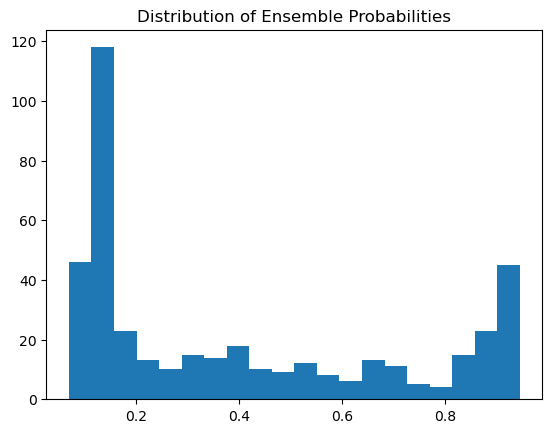

In [20]:
import matplotlib.pyplot as plt
plt.hist(predictions, bins=20)
plt.title("Distribution of Ensemble Probabilities")
plt.show()

In [21]:
# Create an inspector for the last model in the ensemble
inspector = model.make_inspector()

# Display the feature importance based on 'SUM_SCORE'
importances = inspector.variable_importances()["SUM_SCORE"]
for importance in importances:
    print(importance)

("Fare" (1; #3), 185.78414426095287)
("Sex" (4; #7), 178.9200153996935)
("Name" (5; #4), 165.94886933210148)
("Age" (1; #0), 121.95399654841822)
("Ticket_item" (4; #9), 104.37513519957429)
("Pclass" (1; #6), 52.217200391809456)
("Embarked" (4; #2), 34.5751259092649)
("SibSp" (1; #8), 24.31657773004281)
("Ticket_number" (4; #10), 19.45491489219421)
("Parch" (1; #5), 5.99614312115591)


In [22]:
# 1. Generate predictions from the tuned model we created earlier
# We'll use the same serving_ds we just updated
tuned_proba = tuned_model.predict(serving_ds, verbose=0)[:,0]

# 2. Save it to the variable name our comparison code expects
tuned_predictions = pd.DataFrame({
    "Survived": (tuned_proba >= 0.5).astype(int)
})

# 3. Now run the comparison again!
comparison = (kaggle_predictions["Survived"] == tuned_predictions["Survived"]).value_counts()
print(f"Agreement between models: \n{comparison}")

Agreement between models: 
True     337
False     81
Name: Survived, dtype: int64


In [23]:
# Create the new feature in both DataFrames
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
serving_df['FamilySize'] = serving_df['SibSp'] + serving_df['Parch'] + 1

# Let's see the distribution of family sizes
print(train_df['FamilySize'].value_counts())

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64


In [24]:
# 1. Add 'FamilySize' to the features we want the model to use
if "FamilySize" not in input_features:
    input_features.append("FamilySize")

# 2. Update the preprocessed dataframes
preprocessed_train_df['FamilySize'] = train_df['FamilySize']
preprocessed_serving_df['FamilySize'] = serving_df['FamilySize']

# 3. Refresh the TF datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(preprocessed_train_df, label="Survived").map(tokenize_names)
serving_ds = tfdf.keras.pd_dataframe_to_tf_dataset(preprocessed_serving_df).map(tokenize_names)

In [25]:
predictions = None
num_predictions = 0

# Train the 100-model ensemble with all our engineered features
for i in range(100):
    if i % 10 == 0: 
        print(f"Training model i:{i}...")
        
    model = tfdf.keras.GradientBoostedTreesModel(
        verbose=0,
        features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
        exclude_non_specified_features=True,
        random_seed=i,
        honest=True,
    )
    model.fit(train_ds)
    
    sub_predictions = model.predict(serving_ds, verbose=0)[:,0]
    
    if predictions is None:
        predictions = sub_predictions
    else:
        predictions += sub_predictions
    num_predictions += 1

predictions /= num_predictions

# Create the final submission
kaggle_predictions = pd.DataFrame({
        "PassengerId": serving_df["PassengerId"],
        "Survived": (predictions >= 0.5).astype(int)
    })

make_submission(kaggle_predictions)

Training model i:0...


[INFO 2026-01-03T10:29:54.941062001+00:00 kernel.cc:1214] Loading model from path /tmp/tmp09wuugl8/model/ with prefix ea188381e23d4dba
[INFO 2026-01-03T10:29:54.945973215+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:29:56.350788877+00:00 kernel.cc:1214] Loading model from path /tmp/tmp35y6cm2x/model/ with prefix 0fc71d799a154175
[INFO 2026-01-03T10:29:56.359356643+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:29:58.192701701+00:00 kernel.cc:1214] Loading model from path /tmp/tmpgoep34gd/model/ with prefix 9f498bb9a3ae4797
[INFO 2026-01-03T10:29:58.212012245+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:29:59.688184647+00:00 kernel.cc:1214] Loading model from path /tmp/tmpfd52wqdl/model/ with prefix 326c23214ef34eb4
[INFO 2026-01-03T10:29:59.69815373+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:29:59.698201098+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-0

Training model i:10...


[INFO 2026-01-03T10:30:10.734914785+00:00 kernel.cc:1214] Loading model from path /tmp/tmpbkdfue81/model/ with prefix dcf5cffbe22e4c3f
[INFO 2026-01-03T10:30:10.739365768+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:30:10.739419629+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:30:12.28766641+00:00 kernel.cc:1214] Loading model from path /tmp/tmp9ehxgnwz/model/ with prefix f1e0938db43d45d5
[INFO 2026-01-03T10:30:12.297881842+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:30:14.28694845+00:00 kernel.cc:1214] Loading model from path /tmp/tmp23xqynrj/model/ with prefix 2adb7d5526fa4de1
[INFO 2026-01-03T10:30:14.309697934+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:30:15.894757295+00:00 kernel.cc:1214] Loading model from path /tmp/tmpw75l9r4v/model/ with prefix f4f9b1f8b4f74fd8
[INFO 2026-01-03T10:30:15.905605131+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01

Training model i:20...


[INFO 2026-01-03T10:30:28.406569533+00:00 kernel.cc:1214] Loading model from path /tmp/tmpeey_ytv_/model/ with prefix 7995d5335c23476d
[INFO 2026-01-03T10:30:28.423155479+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:30:29.849553421+00:00 kernel.cc:1214] Loading model from path /tmp/tmpaqg44_zo/model/ with prefix bd53581c934243a2
[INFO 2026-01-03T10:30:29.855659483+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:30:31.330278416+00:00 kernel.cc:1214] Loading model from path /tmp/tmpff4j87qa/model/ with prefix 396469faa50b471c
[INFO 2026-01-03T10:30:31.33699322+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:30:33.060090402+00:00 kernel.cc:1214] Loading model from path /tmp/tmpbubv27jm/model/ with prefix 4ae5ae74810941bf
[INFO 2026-01-03T10:30:33.074815733+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:30:33.074882+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-0

Training model i:30...


[INFO 2026-01-03T10:30:44.010305832+00:00 kernel.cc:1214] Loading model from path /tmp/tmpvrx_j9ax/model/ with prefix 70d4fb1debdc43b0
[INFO 2026-01-03T10:30:44.024490479+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:30:44.024539642+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:30:45.815539957+00:00 kernel.cc:1214] Loading model from path /tmp/tmpu0f1m5a6/model/ with prefix 5c54fb31f27441aa
[INFO 2026-01-03T10:30:45.831343096+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:30:47.305838846+00:00 kernel.cc:1214] Loading model from path /tmp/tmpwbmu91za/model/ with prefix afb86c10ee594651
[INFO 2026-01-03T10:30:47.316201827+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:30:48.808806787+00:00 kernel.cc:1214] Loading model from path /tmp/tmpz8g6ez_x/model/ with prefix 3477f8d5898c446d
[INFO 2026-01-03T10:30:48.819341436+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-

Training model i:40...


[INFO 2026-01-03T10:30:59.995634105+00:00 kernel.cc:1214] Loading model from path /tmp/tmpu548lyku/model/ with prefix bf8749cdfa1f48b1
[INFO 2026-01-03T10:31:00.001623041+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:31:01.51575047+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0tqo05iv/model/ with prefix 45aa77e141d34968
[INFO 2026-01-03T10:31:01.524502027+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:31:03.544628379+00:00 kernel.cc:1214] Loading model from path /tmp/tmp7shoadeu/model/ with prefix ed7c258cad1d4bdf
[INFO 2026-01-03T10:31:03.553537466+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:31:05.097055909+00:00 kernel.cc:1214] Loading model from path /tmp/tmpp0w_tr4n/model/ with prefix 531bed03badf461a
[INFO 2026-01-03T10:31:05.10453257+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:31:05.104579333+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01

Training model i:50...


[INFO 2026-01-03T10:31:15.52028562+00:00 kernel.cc:1214] Loading model from path /tmp/tmpduv78vzf/model/ with prefix b53bea90e97f4b15
[INFO 2026-01-03T10:31:15.53379823+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:31:15.533858174+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:31:17.185740064+00:00 kernel.cc:1214] Loading model from path /tmp/tmpyfubkiyx/model/ with prefix 2bf4cf40094547e0
[INFO 2026-01-03T10:31:17.200765938+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:31:18.637466672+00:00 kernel.cc:1214] Loading model from path /tmp/tmpfhx98xjo/model/ with prefix ad1bd638f2c647d6
[INFO 2026-01-03T10:31:18.645415487+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:31:20.465919458+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0_2qqqa7/model/ with prefix 7b66b5be8c5e4851
[INFO 2026-01-03T10:31:20.484360611+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01

Training model i:60...


[INFO 2026-01-03T10:31:31.508519196+00:00 kernel.cc:1214] Loading model from path /tmp/tmp6d4nb8ty/model/ with prefix 474b810a5fb74c54
[INFO 2026-01-03T10:31:31.515692053+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:31:34.439578089+00:00 kernel.cc:1214] Loading model from path /tmp/tmpeq893p5r/model/ with prefix 018d05fbcecb4c0f
[INFO 2026-01-03T10:31:34.445244848+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:31:36.379319696+00:00 kernel.cc:1214] Loading model from path /tmp/tmp_u9z0lvm/model/ with prefix 1f76f18a071a488e
[INFO 2026-01-03T10:31:36.394637125+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:31:36.394686629+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:31:38.017077275+00:00 kernel.cc:1214] Loading model from path /tmp/tmpjmd0uair/model/ with prefix fbac427d49b44bd8
[INFO 2026-01-03T10:31:38.025305092+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-

Training model i:70...


[INFO 2026-01-03T10:31:49.76080992+00:00 kernel.cc:1214] Loading model from path /tmp/tmphcrek379/model/ with prefix be80e81793d64484
[INFO 2026-01-03T10:31:49.767691264+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:31:51.317914878+00:00 kernel.cc:1214] Loading model from path /tmp/tmpyo5yzbg0/model/ with prefix ff4f536f8d1c466d
[INFO 2026-01-03T10:31:51.325876903+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:31:52.818606859+00:00 kernel.cc:1214] Loading model from path /tmp/tmp55m8yno_/model/ with prefix c19bffdd0ecb40d5
[INFO 2026-01-03T10:31:52.827468236+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:31:54.250650557+00:00 kernel.cc:1214] Loading model from path /tmp/tmpo8ls3bxq/model/ with prefix cabb79480209411b
[INFO 2026-01-03T10:31:54.257256815+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:31:55.96376618+00:00 kernel.cc:1214] Loading model from path /tmp/tmpgegi8xvk/model/ with prefix 838326cd5ba44573

Training model i:80...


[INFO 2026-01-03T10:32:05.364818198+00:00 kernel.cc:1214] Loading model from path /tmp/tmpxaea7ohk/model/ with prefix d90da15bf76148b1
[INFO 2026-01-03T10:32:05.378370325+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:32:06.893172509+00:00 kernel.cc:1214] Loading model from path /tmp/tmpz0d7a0ob/model/ with prefix 242bce78dee84844
[INFO 2026-01-03T10:32:06.901623005+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:32:08.738539551+00:00 kernel.cc:1214] Loading model from path /tmp/tmp_ncihr_l/model/ with prefix c51c7f0a1a974ff8
[INFO 2026-01-03T10:32:08.751828731+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2026-01-03T10:32:08.751880599+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:32:10.74260156+00:00 kernel.cc:1214] Loading model from path /tmp/tmpu4wlgqrb/model/ with prefix 8cf9216267914792
[INFO 2026-01-03T10:32:10.758588675+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-0

Training model i:90...


[INFO 2026-01-03T10:32:22.153667411+00:00 kernel.cc:1214] Loading model from path /tmp/tmpa9womjeh/model/ with prefix f032d50ecc074e32
[INFO 2026-01-03T10:32:22.176161434+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:32:23.698596795+00:00 kernel.cc:1214] Loading model from path /tmp/tmp_59h_a0i/model/ with prefix 11026cc5131948e7
[INFO 2026-01-03T10:32:23.707781186+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:32:25.296845877+00:00 kernel.cc:1214] Loading model from path /tmp/tmpvugi9r3q/model/ with prefix 5f204b181df64e40
[INFO 2026-01-03T10:32:25.307146039+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:32:26.728917393+00:00 kernel.cc:1214] Loading model from path /tmp/tmp74ld2jws/model/ with prefix 9e4a2d51ad714d95
[INFO 2026-01-03T10:32:26.735224835+00:00 kernel.cc:1046] Use fast generic engine
[INFO 2026-01-03T10:32:28.035648022+00:00 kernel.cc:1214] Loading model from path /tmp/tmp7hduiaoy/model/ with prefix 620f0d65fbb846

Submission exported to /kaggle/working/submission.csv


In [26]:
print(kaggle_predictions["Survived"].value_counts())

0    275
1    143
Name: Survived, dtype: int64


In [27]:
# Create an inspector for the latest version of the model
inspector = model.make_inspector()

# Display the feature importance based on 'SUM_SCORE'
importances = inspector.variable_importances()["SUM_SCORE"]
for importance in importances:
    print(importance)

("Sex" (4; #8), 144.8645752783632)
("Fare" (1; #4), 130.30653914514642)
("Name" (5; #5), 108.73884733894911)
("Age" (1; #0), 79.90281651221164)
("Ticket_item" (4; #10), 54.856604266533395)
("Pclass" (1; #7), 42.24658777843433)
("Ticket_number" (4; #11), 24.711491872702027)
("Embarked" (4; #2), 17.01524106618308)
("FamilySize" (1; #3), 11.310304926460958)
("SibSp" (1; #9), 9.163572105928324)
("Parch" (1; #6), 0.2582880006812047)


In [28]:
# Create the final submission file from our 100-model ensemble
make_submission(kaggle_predictions)

# Let's take a quick peek at the first few rows to ensure it looks right
!head /kaggle/working/submission.csv

Submission exported to /kaggle/working/submission.csv
PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
